In [85]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
import matplotlib.patches as patches
import cv2
import pandas as pd
import sys
import poissonimageediting as poisson
from tqdm.auto import tqdm

np.set_printoptions(threshold=sys.maxsize)

In [86]:
image = cv2.imread('data/01.jpg').astype(np.uint8)
dataset_images_dir = "data/holiday_images"
target_df = pd.read_pickle('data/target_df.pkl')
dataset_df = pd.read_pickle('data/holiday_df.pkl')

In [87]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

target_descriptors = np.array(target_df['descriptor'].tolist(), dtype = np.float32)
dataset_descriptors = np.array(dataset_df['descriptor'].tolist(), dtype = np.float32)

matches = matcher.match(target_descriptors, dataset_descriptors)

target_df['match_idx'] = np.array([match.trainIdx for match in matches])

In [88]:
target_df = target_df.sort_values(by = ['size'], ascending = [False])
print(target_df.shape)

(2927, 13)


In [89]:
dataset_df.shape


(152327, 12)

In [90]:
target_df

,image_name,coordinate,scale,orientation,matrix,eigenvalues,eigenvectors,semi_major_axis,semi_minor_axis,size,angle,descriptor,match_idx
2926,01.jpg,"(1377.81, 619.604)",648.550956,148.606125,"[[4.08482e-06, 2.79779e-06], [2.79779e-06, 6.9...","[2.377452187750583e-06, 8.669437812249417e-06]","[[-0.853606488942358, -0.5209183832765936], [0...",648.550956,339.628817,691987.913525,2.593666,"[102.0, 10.0, 1.0, 0.0, 19.0, 2.0, 0.0, 8.0, 6...",6786
2925,01.jpg,"(1141.11, 611.669)",478.464159,161.486288,"[[4.76484e-06, 1.18453e-06], [1.18453e-06, 7.9...","[4.3681865657550784e-06, 8.302213434244922e-06]","[[-0.9482476915319418, -0.3175315976471374], [...",478.464159,347.058794,521677.776591,2.818467,"[21.0, 4.0, 4.0, 7.0, 10.0, 40.0, 36.0, 35.0, ...",64419
2922,01.jpg,"(1117.15, 800.614)",463.245344,165.478343,"[[5.10343e-06, 1.71228e-06], [1.71228e-06, 1.1...","[4.659913696910548e-06, 1.1714016303089451e-05]","[[-0.9680529293766331, -0.25074593900065323], ...",463.245344,292.177715,425214.459025,2.888142,"[29.0, 1.0, 1.0, 0.0, 12.0, 5.0, 3.0, 40.0, 12...",41930
2921,01.jpg,"(1224.23, 740.244)",468.345829,162.030418,"[[5.64613e-06, 3.35199e-06], [3.35199e-06, 1.4...","[4.558969497005411e-06, 1.5981160502994587e-05]","[[-0.9512204362877029, -0.3085120444790318], [...",468.345829,250.147314,368054.704123,2.827964,"[77.0, 2.0, 0.0, 0.0, 0.0, 2.0, 10.0, 48.0, 67...",100154
2923,01.jpg,"(1272.17, 877.82)",363.875238,108.731410,"[[1.234e-05, 1.62338e-06], [1.62338e-06, 8.103...","[7.5525740918668066e-06, 1.2890475908133194e-05]","[[-0.32113220970016976, 0.9470343731317709], [...",363.875238,278.525860,318396.217471,1.897721,"[0.0, 1.0, 0.0, 4.0, 8.0, 5.0, 138.0, 81.0, 5....",17015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,01.jpg,"(895.392, 446.274)",17.629437,156.808104,"[[0.0115976, 0.0195598], [0.0195598, 0.0488718]]","[0.003217533745005753, 0.057251866254994246]","[[-0.9191910523486986, -0.3938118958107946], [...",17.629437,4.179316,231.469351,2.736818,"[135.0, 11.0, 1.0, 1.0, 0.0, 0.0, 0.0, 3.0, 24...",11560
125,01.jpg,"(1334.81, 513.407)",15.729745,87.705516,"[[0.0482413, -0.00177098], [-0.00177098, 0.004...","[0.0040416308679072505, 0.04831225913209275]","[[0.040035596618692285, 0.9991982541034513], [...",15.729745,4.549580,224.824107,1.530750,"[0.0, 0.0, 0.0, 10.0, 82.0, 0.0, 0.0, 0.0, 0.0...",87853
709,01.jpg,"(1060.58, 1829.35)",10.913934,-168.922954,"[[0.00898956, -0.00303529], [-0.00303529, 0.02...","[0.008395322501354585, 0.024493437498645416]","[[-0.9813697145974631, 0.19212881946988997], [...",10.913934,6.389621,219.081805,-2.948262,"[3.0, 19.0, 11.0, 0.0, 0.0, 7.0, 20.0, 14.0, 3...",139485
248,01.jpg,"(748.412, 959.557)",12.476982,92.634575,"[[0.0380172, 0.00145376], [0.00145376, 0.00649...","[0.00642363605472492, 0.03808409394527508]","[[-0.04596579856113536, 0.9989430140716923], [...",12.476982,5.124225,200.857288,1.616778,"[0.0, 0.0, 0.0, 2.0, 31.0, 30.0, 10.0, 0.0, 0....",87755


In [91]:
u,v = target_df.iloc[0]['coordinate']
A = target_df.iloc[0]['matrix']
major_axis_length = target_df.iloc[0]['semi_major_axis']
minor_axis_length = target_df.iloc[0]['semi_minor_axis']
angle = target_df.iloc[0]['angle']

u2,v2 = target_df.iloc[2]['coordinate']
A2 = target_df.iloc[2]['matrix']
major_axis_length2 = target_df.iloc[2]['semi_major_axis']
minor_axis_length2 = target_df.iloc[2]['semi_minor_axis']
angle2 = target_df.iloc[2]['angle']


In [92]:
def warp_and_paste_ellipse(source_image_path, destination_image, source_params, destination_params):
    source_image = cv2.imread(source_image_path).astype(np.uint8)

    u, v, major_axis_length, minor_axis_length, angle = source_params
    u2, v2, major_axis_length2, minor_axis_length2, angle2 = destination_params

    # Define the source ellipse parameters
    center1 = (int(u), int(v))
    axes1 = (int(major_axis_length), int(minor_axis_length))
    angle1 = np.degrees(angle)

    # Define the destination ellipse parameters
    center2 = (int(u2), int(v2))
    axes2 = (int(major_axis_length2), int(minor_axis_length2))
    angle2 = np.degrees(angle2)

    # Create a mask for the source ellipse
    mask = np.zeros_like(source_image)
    cv2.ellipse(mask, center1, axes1, angle1, 0, 360, (255, 255, 255), -1)

    # Extract the source ellipse region
    source_ellipse_region = cv2.bitwise_and(source_image, mask)

    # Define the bounding box around the source ellipse
    src_rect = cv2.boxPoints(((center1[0], center1[1]), (axes1[0] * 2, axes1[1] * 2), angle1))
    src_rect = np.int0(src_rect)

    # Define the bounding box around the destination ellipse
    dst_rect = cv2.boxPoints(((center2[0], center2[1]), (axes2[0] * 2, axes2[1] * 2), angle2))
    dst_rect = np.int0(dst_rect)

    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(np.float32(src_rect), np.float32(dst_rect))

    # warp
    warped_ellipse_region = cv2.warpPerspective(source_ellipse_region, M, (destination_image.shape[1], destination_image.shape[0]))

    # Create a mask for the destination ellipse to combine the images correctly
    mask2 = np.zeros_like(destination_image)
    cv2.ellipse(mask2, center2, axes2, angle2, 0, 360, (255, 255, 255), -1)

    warped_ellipse_only = cv2.bitwise_and(warped_ellipse_region, mask2)
    result = cv2.add(cv2.bitwise_and(destination_image, cv2.bitwise_not(mask2)), warped_ellipse_only)

    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    return result_rgb

In [95]:
canvas = np.zeros_like(image)
for index, row in tqdm(target_df.iterrows(), total=target_df.shape[0]):
    target_u, target_v = row['coordinate']
    target_A = row['matrix']
    target_major_axis_length = row['semi_major_axis']
    target_minor_axis_length = row['semi_minor_axis']
    target_angle = row['angle']
    
    match_idx = row['match_idx']
    match_image_name  = dataset_df.loc[match_idx, 'image_name']
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_major_axis_length = dataset_df.loc[match_idx, 'semi_major_axis']
    match_minor_axis_length = dataset_df.loc[match_idx, 'semi_minor_axis']
    match_angle = dataset_df.loc[match_idx, 'angle']
    
    match_image_path = f"{dataset_images_dir}/{match_image_name}"

    
    source_params = (match_u, match_v, match_major_axis_length, match_minor_axis_length, match_angle)
    destination_params = (target_u, target_v, target_major_axis_length, target_minor_axis_length, target_angle)

    result = warp_and_paste_ellipse(match_image_path, canvas, source_params, destination_params)
    
    canvas = result

  0%|          | 0/2927 [00:00<?, ?it/s]/tmp/ipykernel_1357/1853938510.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  src_rect = np.int0(src_rect)
/tmp/ipykernel_1357/1853938510.py:32: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  dst_rect = np.int0(dst_rect)
100%|██████████| 2927/2927 [04:24<00:00, 11.09it/s]


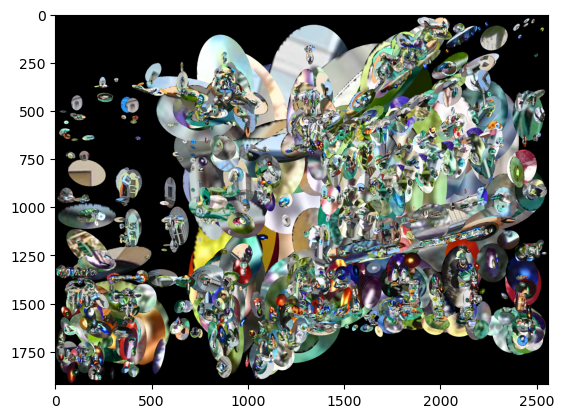

In [96]:
plt.imshow(canvas)